# Audio Features Analysis

## Overview

This notebook performs an in-depth analysis of the audio features included in the processed Spotify dataset. Goals:

- Inspect per-genre distributions for key audio features
- Identify strong feature correlations that could affect modeling
- Visualize discriminative features across genres
- Reduce dimensionality with PCA to inspect separability between genres

This analysis helps inform feature selection and preprocessing choices for building a music recommender system.

### Environment and Imports

We import the standard data science libraries and configure plotting defaults. These libraries are used for data manipulation (`pandas`, `numpy`) and visualization (`matplotlib`, `seaborn`).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Visualization Configuration

Set plotting style and default figure sizes to create consistent, publication-quality visuals during the analysis.

In [3]:
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
# Load processed, balanced Spotify dataset
df = pd.read_csv('../data/processed/spotify_clean_balanced.csv')
print(f"Dataset shape: {df.shape}")
print(f"Genres: {df['general_genre'].unique()}")

Dataset shape: (217117, 18)
\Genres: ['Classical' 'Rock' 'Soundtrack' 'Electronic' 'Pop' 'Latin' 'Hip Hop'
 'Country' 'Jazz']


### Audio Features Selected

List of audio features used across this notebook. These features are commonly used to represent acoustic characteristics for content-based music models.

In [5]:
audio_features = [
    'acousticness', 'danceability', 'energy', 
    'instrumentalness', 'liveness', 'loudness',
    'speechiness', 'tempo', 'valence'
]

### Per-Genre Descriptive Statistics

For each audio feature we compute per-genre descriptive statistics. These summaries help detect large inter-genre differences and potential outliers.

In [6]:
print("=== AUDIO FEATURES PER GENRE ===\n")
for feature in audio_features:
    print(f"\n{feature.upper()}:")
    print(df.groupby('general_genre')[feature].describe()[['mean', 'std', 'min', 'max']])

=== AUDIO FEATURES PER GENRE ===


ACOUSTICNESS:
                   mean       std       min    max
general_genre                                     
Classical      0.939140  0.093624  0.000015  0.996
Country        0.375899  0.305065  0.000014  0.995
Electronic     0.082279  0.178091  0.000002  0.996
Hip Hop        0.169682  0.201944  0.000003  0.995
Jazz           0.680677  0.291084  0.000005  0.996
Latin          0.352885  0.243858  0.000099  0.995
Pop            0.207268  0.272627  0.000000  0.996
Rock           0.222647  0.286842  0.000001  0.996
Soundtrack     0.609268  0.339938  0.000001  0.996

DANCEABILITY:
                   mean       std    min    max
general_genre                                  
Classical      0.309201  0.136532  0.000  0.935
Country        0.565416  0.110503  0.112  0.951
Electronic     0.604879  0.146620  0.000  0.988
Hip Hop        0.704622  0.143127  0.000  0.988
Jazz           0.527298  0.150254  0.000  0.981
Latin          0.670351  0.136678  0.12

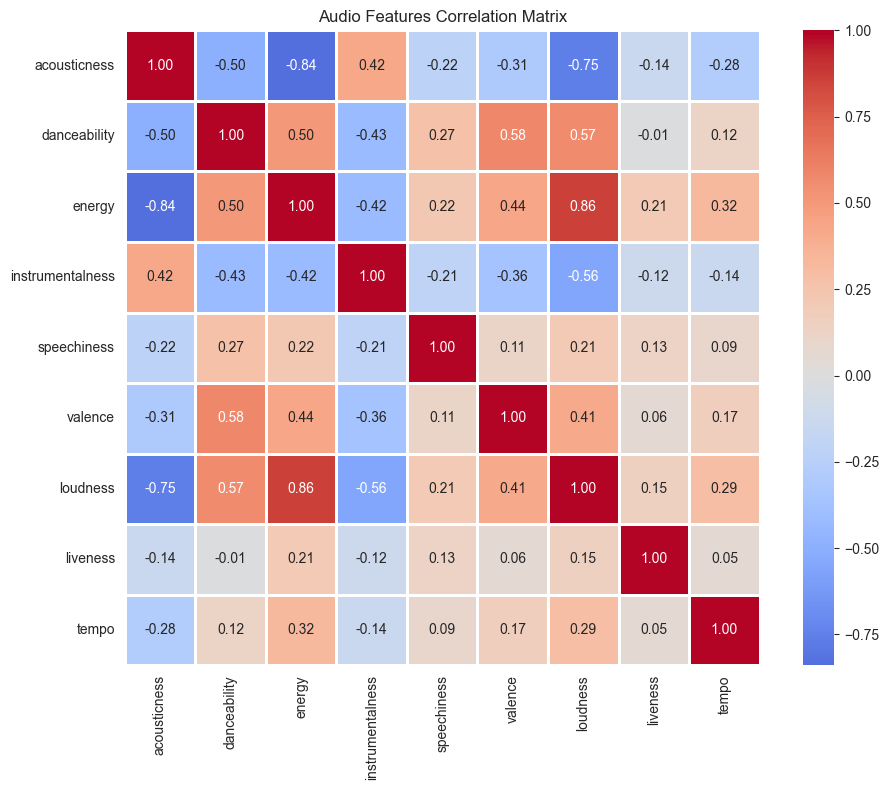


=== STRONG CORRELATIONS ===
acousticness vs energy: -0.839
acousticness vs loudness: -0.755
energy vs loudness: 0.860


In [ ]:
import seaborn as sns

# Correlation matrix
audio_features_to_check = [
    'acousticness', 'danceability', 'energy',
    'instrumentalness', 'speechiness', 'valence',
    'loudness', 'liveness', 'tempo'
]

corr_matrix = df[audio_features_to_check].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Audio Features Correlation Matrix')
plt.tight_layout()
plt.show()

# Show strong correlations (absolute value > 0.7)
print("\n=== STRONG CORRELATIONS ===")
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            print(f"{corr_matrix.columns[i]} vs {corr_matrix.columns[j]}: {corr_matrix.iloc[i,j]:.3f}")

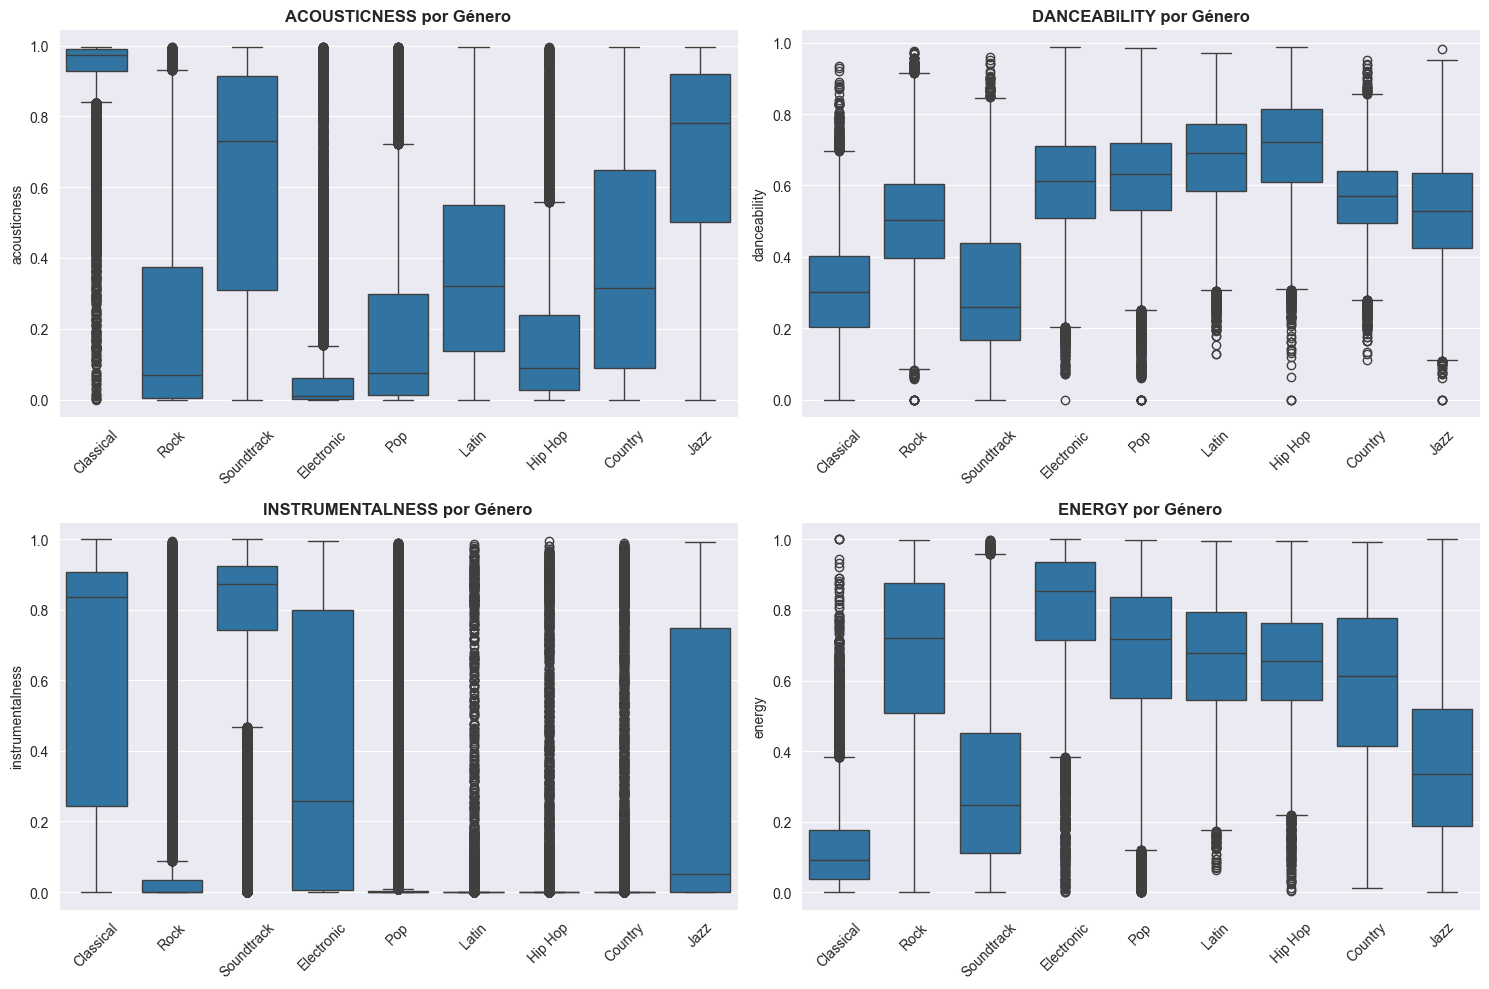

In [ ]:
# Top 4 discriminative features

top_features = ['acousticness', 'danceability', 'instrumentalness', 'energy']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    sns.boxplot(data=df, x='general_genre', y=feature, ax=axes[idx])
    axes[idx].set_title(f'{feature.upper()} by Genre', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

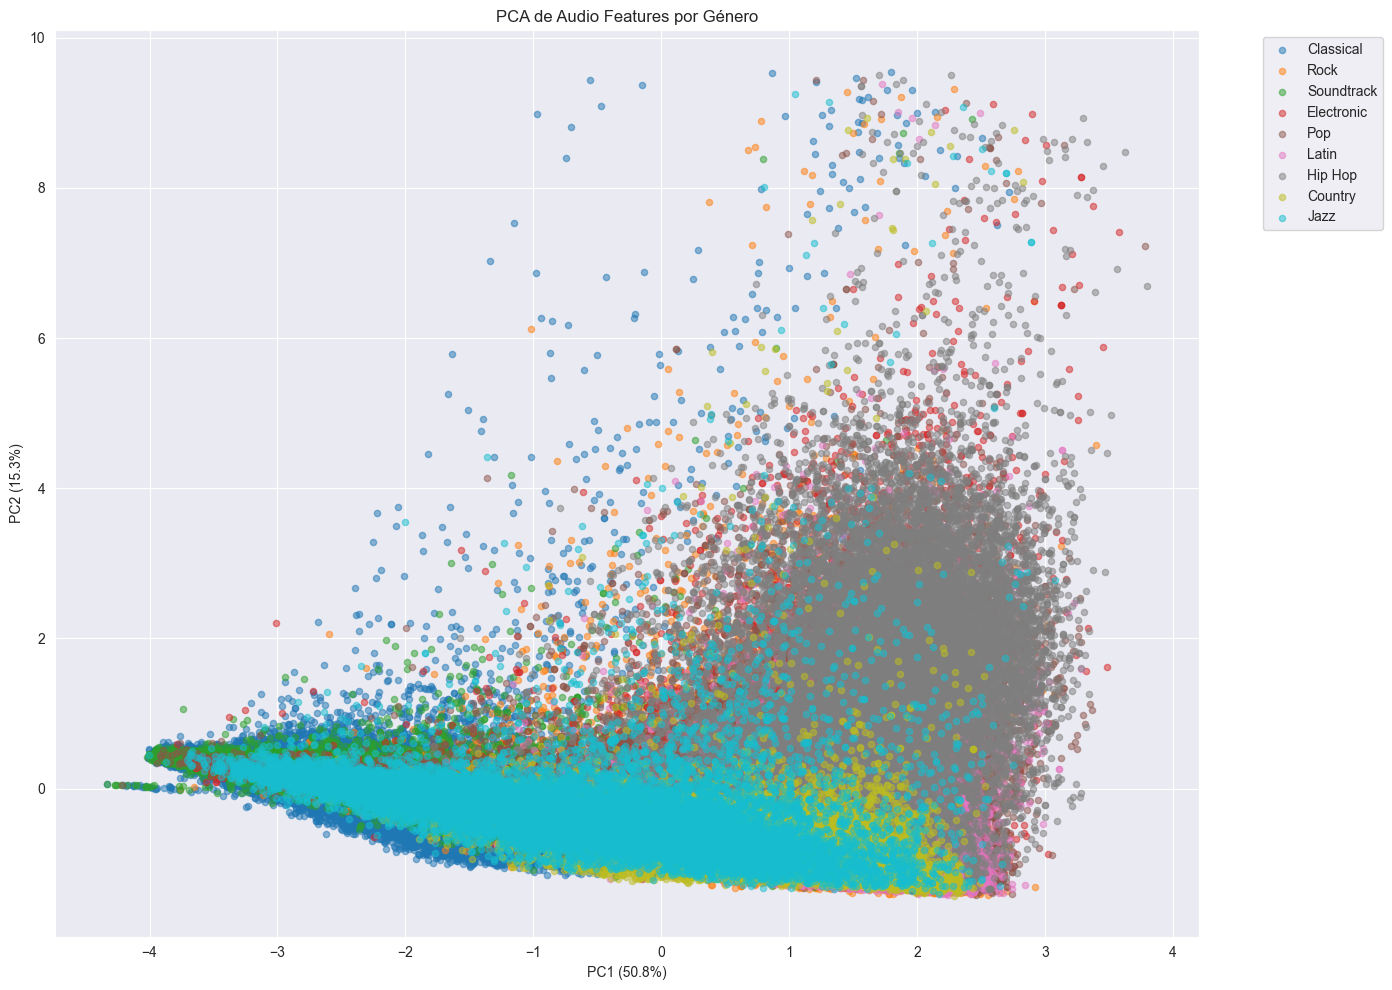

Varianza explicada por PC1: 50.8%
Varianza explicada por PC2: 15.3%


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select features for PCA
features_for_pca = ['acousticness', 'danceability', 'energy',
                    'instrumentalness', 'speechiness', 'valence']

X = df[features_for_pca].values
y = df['general_genre'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA (2 components for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA scatter by genre
plt.figure(figsize=(14, 10))
genres = df['general_genre'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(genres)))

for genre, color in zip(genres, colors):
    mask = y == genre
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                c=[color], label=genre, alpha=0.5, s=20)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('PCA of Audio Features by Genre')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print(f"Explained variance by PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"Explained variance by PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")

## Conclusions & Next Steps

Summary:
- Certain audio features show strong correlations; consider removing or combining highly correlated features during modeling.
- `acousticness`, `danceability`, `instrumentalness`, and `energy` appear to discriminate well across genres.
- PCA shows the degree of overlap between genres when projected to 2D — useful for visual assessment of separability.

Next steps:
1. Consider feature reduction (e.g., remove correlated features or use PCA embeddings) for downstream models.
2. Create feature embeddings for audio features and combine them with genre embeddings for a hybrid recommender.
3. Run feature importance experiments with simple models to validate discriminative power.

This notebook documents the exploratory analysis of audio features and provides guidance for the preprocessing choices in the recommender pipeline.